In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
sns.set_style("whitegrid")
plt.rc('font', size=14)

In [3]:
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn
import numpy as np

In [4]:
def annotate_significance(ax, pairs, pvalues, threshold=0.05, df_data=None, column_response=""):
    y_max = df_data[column_response].max() + 1  # Espacio por encima de los boxplots
    h = 0.2  # Altura de las líneas de significancia
    for pair, pval in zip(pairs, pvalues):
        if pval < threshold:
            i, j = pair
            x1, x2 = i, j
            y = y_max
            y_max += h
            # Dibujar las líneas que conectan los grupos comparados
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color='k')
            # Añadir un asterisco para significancia
            ax.text((x1 + x2) * .5, y + h, f"* (p={pval:.3f})", ha='center', va='bottom', color='k')
    return ax

In [5]:
def process_dunn(fig, dunn_test, alpha, df_data, column_response,gs, palette):
    # Establecer un umbral de significancia
    sig_pairs = np.where(dunn_test < alpha)  # Pares de comparaciones significativas
    ax_data = fig.add_subplot(gs)
    sns.boxplot(x='MSPH', y=column_response, data=df_data, fill=False, palette=palette)
    pairs = list(zip(*sig_pairs))
    pvalues = dunn_test.values[sig_pairs]
    annotate_significance(ax_data, pairs, pvalues, threshold=0.05, df_data=df_data, column_response=column_response)


In [6]:
def make_comparison_with_categories(dataset, response, column_category):
    categories = dataset[column_category].unique()

    data = []

    for category in categories:
        data.append(dataset[dataset[column_category] == category][response])

    response_kruskal = kruskal(*data)
    
    dunn_df = posthoc_dunn(
        dataset, val_col=response, group_col=column_category, p_adjust="fdr_bh"
    )
    
    return response_kruskal, dunn_df

In [7]:
df_data = pd.read_csv("../../results/processed_dataset/1_processed_input_dataset.csv")
df_data

,Age,Weight,Height,Clycemia,Systolic blood pressure,Diastolic blood pressure,Cholesterol,Triglycerides,HDL,LDL,MSPH,BMI
0,21,63.0,158.0,70.0,96.0,64.0,140,75.0,61.0,64.0,0,25.2
1,20,112.0,164.0,77.0,80.0,60.0,126,81.0,36.0,74.0,0,41.6
2,19,77.8,165.0,93.0,102.0,64.0,149,105.0,56.0,73.0,0,28.6
3,29,92.0,165.0,90.0,110.0,70.0,149,144.0,49.0,71.0,0,33.8
4,18,79.0,160.0,66.0,106.0,60.0,167,150.0,22.0,115.0,0,30.9
...,...,...,...,...,...,...,...,...,...,...,...,...
143,30,53.0,156.0,85.1,140.0,88.0,158,55.0,43.5,103.5,0,21.8
144,32,63.0,169.0,74.2,109.0,72.0,238,123.0,84.1,129.3,0,22.1
145,34,66.0,155.0,79.5,104.0,69.0,216,183.0,56.8,122.6,0,27.5
146,37,88.5,171.0,85.2,106.0,53.0,146,97.0,54.0,72.6,0,30.3


In [8]:
palette_values = ['#026E81', '#00ABBD', '#0099DD', '#FF9933', '#A1C7E0']
colors = sns.color_palette(palette_values)
colors

[(0.00784313725490196, 0.43137254901960786, 0.5058823529411764),
 (0.0, 0.6705882352941176, 0.7411764705882353),
 (0.0, 0.6, 0.8666666666666667),
 (1.0, 0.6, 0.2),
 (0.6313725490196078, 0.7803921568627451, 0.8784313725490196)]

In [9]:
df_data["MSPH"] = df_data["MSPH"].replace(
    {0 : "Negative", 1: "Positive"}
)

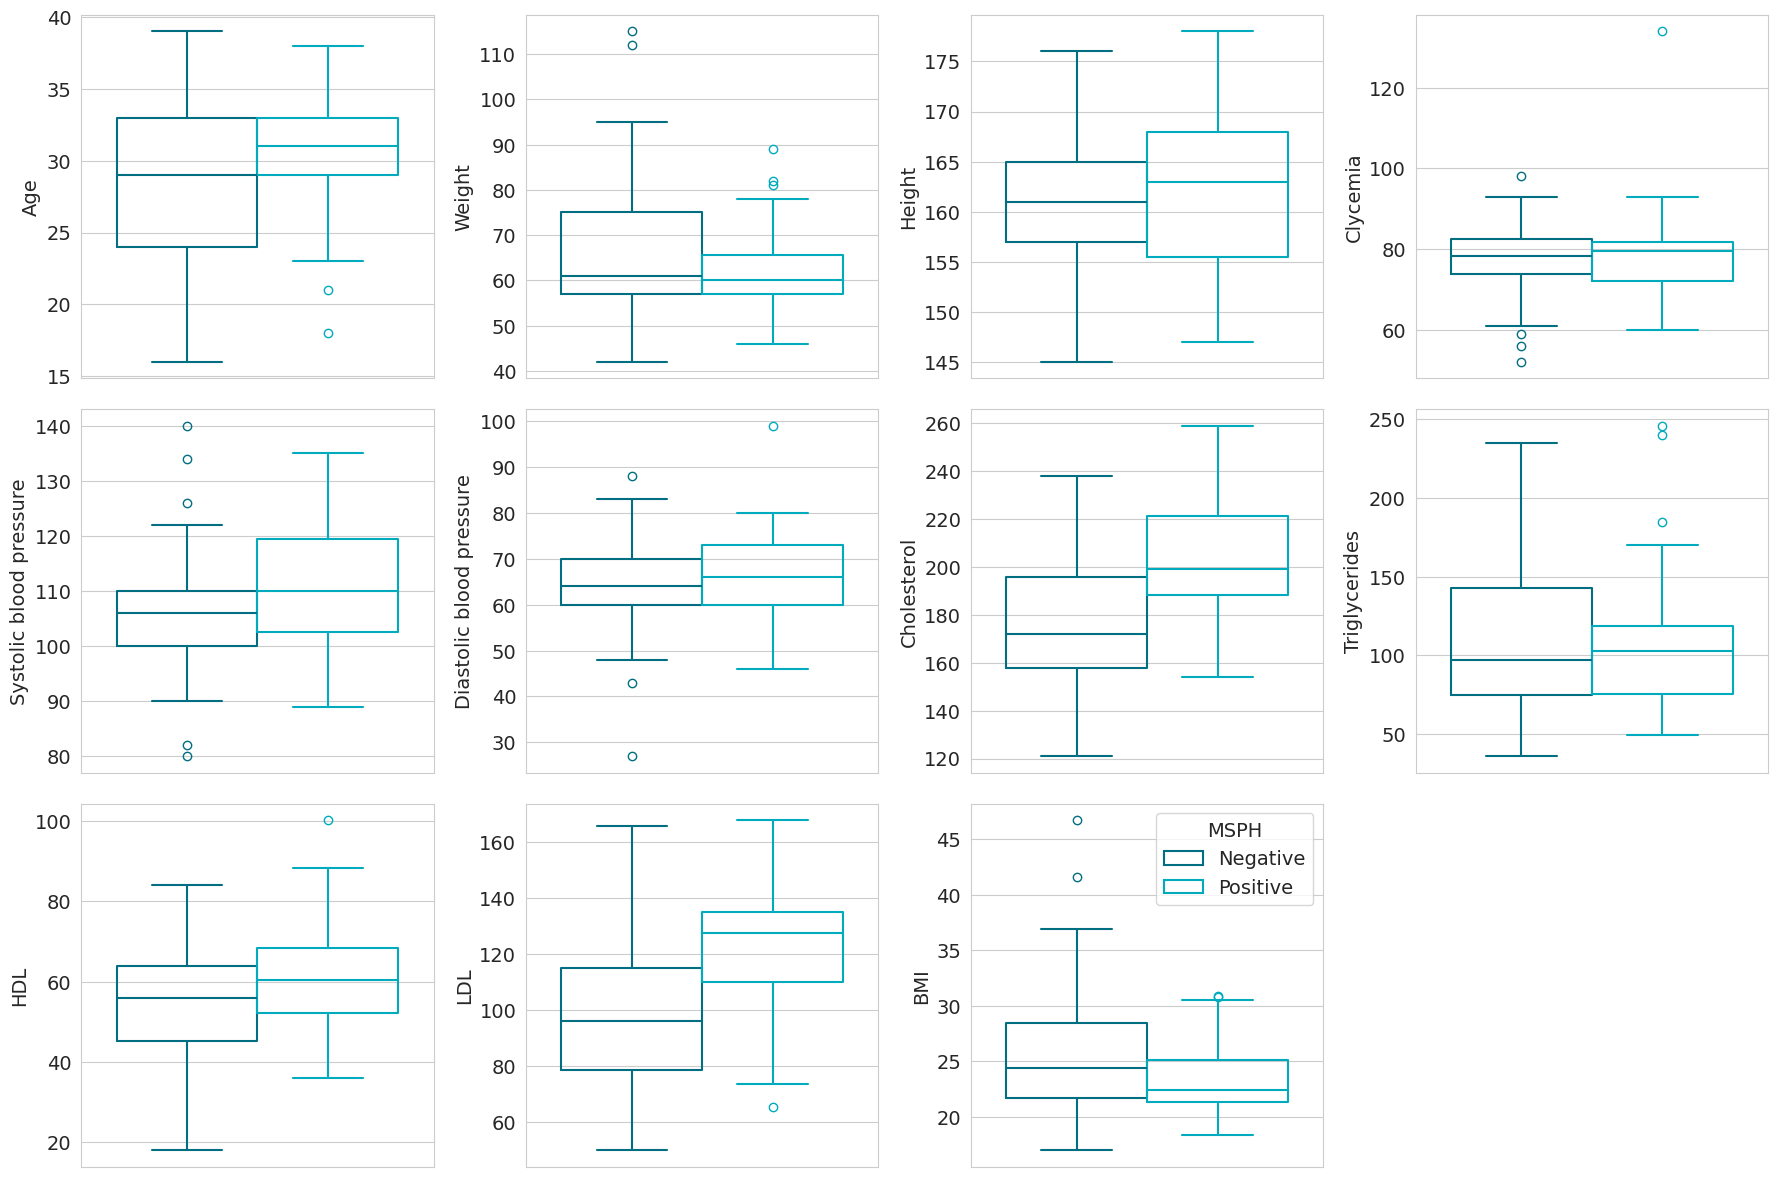

In [10]:
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 4, figure=fig)

index=0
x_value = 0
y_value = 0

for column in df_data.columns:

    if column != "MSPH":
        ax_data = fig.add_subplot(gs[x_value, y_value])

        if index != 10:
            sns.boxplot(data=df_data, hue="MSPH", y=column, ax=ax_data, fill=False, legend=False, palette=colors)
        else:
            sns.boxplot(data=df_data, hue="MSPH", y=column, ax=ax_data, fill=False, palette=colors)

        index+=1

        if index in [4,8]:
            x_value+=1
            y_value=0
        else:
            y_value+=1

plt.tight_layout()
plt.savefig("../../results/descriptive_process/1_boxplot_data.png", dpi=300)


In [11]:
matrix_test = []

for column in df_data.columns:
    if column != "MSPH":
        response_kruskal, dunn_df = make_comparison_with_categories(df_data, column, "MSPH")

        row = [column, response_kruskal[0], response_kruskal[1]]
        matrix_test.append(row)

df_comparison = pd.DataFrame(data=matrix_test, columns=["feature", "statistic", "p-value"])
df_comparison["reject"] = df_comparison["p-value"]<0.05
df_comparison = df_comparison[df_comparison["reject"]]
df_comparison

,feature,statistic,p-value,reject
0,Age,4.452181,3.485670e-02,True
4,Systolic blood pressure,5.786073,1.615363e-02,True
6,Cholesterol,27.752217,1.378901e-07,True
8,HDL,4.042500,4.436805e-02,True
9,LDL,26.203987,3.071876e-07,True


In [12]:
df_data.groupby(by="MSPH").std().round(decimals=2).T

MSPH,Negative,Positive
Age,6.00,4.50
Weight,13.56,9.55
Height,6.30,7.42
Clycemia,8.24,11.30
Systolic blood pressure,9.94,10.11
Diastolic blood pressure,8.49,10.47
Cholesterol,25.43,25.78
Triglycerides,44.90,43.41
HDL,12.38,14.44
LDL,23.75,23.59


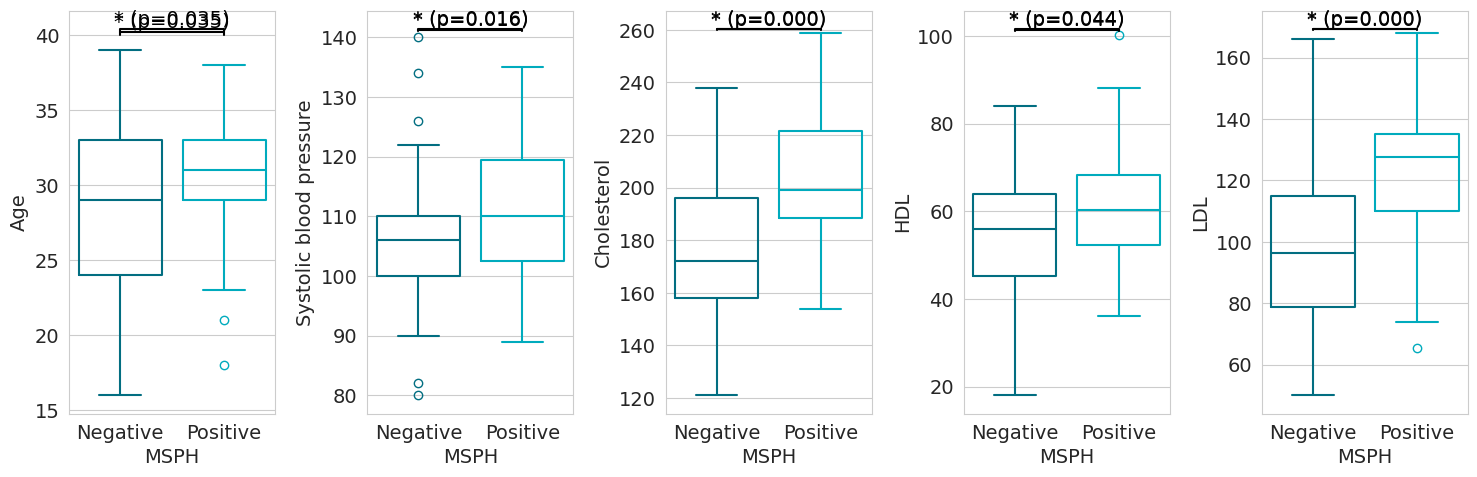

In [13]:
alpha = 0.05

fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 5, figure=fig)

# Realizar el test de Dunn
dunn_test_edad = posthoc_dunn(df_data, val_col='Age', group_col='MSPH', p_adjust='bonferroni')
dunn_test_pas1t = posthoc_dunn(df_data, val_col='Systolic blood pressure', group_col='MSPH', p_adjust='bonferroni')
dunn_test_ct1 = posthoc_dunn(df_data, val_col='Cholesterol', group_col='MSPH', p_adjust='bonferroni')
dunn_test_hdl1 = posthoc_dunn(df_data, val_col='HDL', group_col='MSPH', p_adjust='bonferroni')
dunn_test_ldl1 = posthoc_dunn(df_data, val_col='LDL', group_col='MSPH', p_adjust='bonferroni')

process_dunn(fig, dunn_test_edad, alpha, df_data, 'Age',gs[0], colors)
process_dunn(fig, dunn_test_pas1t, alpha, df_data, 'Systolic blood pressure',gs[1], colors)
process_dunn(fig, dunn_test_ct1, alpha, df_data, 'Cholesterol',gs[2], colors)
process_dunn(fig, dunn_test_hdl1, alpha, df_data, 'HDL',gs[3], colors)
process_dunn(fig, dunn_test_ldl1, alpha, df_data, 'LDL',gs[4], colors)

plt.savefig("../../results/descriptive_process/2_statistical_comparison.png", dpi=300)
plt.tight_layout()